In [1]:
from supplementaryFunctions import *
import wooldridge as woo
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as smo
import scipy.stats as stats
import matplotlib.pyplot as plt

# 9. More on Specification and Data Issues
## 9.1. Functional Form Mispecifications

### Ramsay Reset Test

Ramsey Reset Test checks if addition of transformation of the estimator (raising to powers greater than 1) improves explanation of variance. By running an F-test, we can test if the addition of the transformed estimator as part of the set of explanatory variables improves the explanatory power of the regression.

### Example 9.2: Housing Price Equation

In [2]:
hprice1 = woo.dataWoo("hprice1")
formula = "price ~ lotsize + sqrft + bdrms"
reg = smf.ols(formula = formula,
             data = hprice1)
results = reg.fit()
OLS_summary(results)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.6724$$,,,,
Intercept,-21.7703,-0.7386,0.4622,29.4750
lotsize,0.0021,3.2201,0.0018,0.0006
sqrft,0.1228,9.2751,0.0000,0.0132
bdrms,13.8525,1.5374,0.1279,9.0101


In [3]:
#regression for RESET test:
hprice1["fitted_sq"] = results.fittedvalues ** 2
hprice1["fitted_cube"] = results.fittedvalues ** 3
reset_formula = formula + " + fitted_sq + fitted_cube"
reg_reset = smf.ols(formula = reset_formula,
                   data = hprice1)
results_reset = reg_reset.fit()
OLS_summary(results_reset)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.7059$$,,,,
Intercept,166.0973,0.5233,0.6022,317.4325
lotsize,0.0002,0.0295,0.9765,0.0052
sqrft,0.0176,0.0588,0.9532,0.2993
bdrms,2.1749,0.0642,0.9490,33.8881
fitted_sq,0.0004,0.0498,0.9604,0.0071
fitted_cube,0.0000,0.2358,0.8142,0.0000


In [4]:
reset_tests = {"Manual":{},
              "Auto":{}} 
hypotheses = ["fitted_sq = 0", "fitted_cube = 0"]
ftest_man = results_reset.f_test(hypotheses)
reset_tests["Manual"]["statistic"] = ftest_man.statistic
reset_tests["Manual"]["p-value"] = ftest_man.pvalue

reset_test = smo.reset_ramsey(res = results, degree = 3)
reset_tests["Auto"]["statistic"] = reset_test.statistic
reset_tests["Auto"]["p-value"] = reset_test.pvalue
pd.DataFrame(reset_tests)

,Manual,Auto
statistic,4.668206,4.668206
p-value,0.012022,0.012022


In [5]:
formulas = {}
formulas[1] = "price ~ lotsize + sqrft + bdrms"
formulas[2] = "price ~ np.log(lotsize) + np.log(sqrft) + bdrms"
formulas[3] = "price ~ lotsize + sqrft + bdrms + np.log(lotsize) + np.log(sqrft)"
regs = {}
results = {}

for i, formula in formulas.items():
    regs[i] = smf.ols(formula = formula,
                    data = hprice1)
    results[i] = regs[i].fit()
anova_results = {}
for i in range(1,3):
    anova_results[i] = sm.stats.anova_lm(results[i], results[3])

In [6]:
anova_results[1]

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,84.0,300723.805123,0.0,NaN,NaN,NaN
1,82.0,252340.364481,2.0,48383.440642,7.861291,0.000753


In [7]:
anova_results[2]

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,84.0,295735.273607,0.0,NaN,NaN,NaN
1,82.0,252340.364481,2.0,43394.909126,7.05076,0.001494


The comprehensive model, saved in _results[3]_ generates a statistically significant and differenty mean. We can recreate the result using the _f_test_ method from _results[3]_. Notice that the F-test is really just testing whether there is a statistically significant difference in means between the full regression and the limited regressions.

In [8]:
results[3].f_test(["np.log(lotsize) = 0", "np.log(sqrft) = 0"])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=7.861291119232879, p=0.0007526198013482312, df_denom=82, df_num=2>

In [9]:
results[3].f_test(["lotsize = 0", "sqrft = 0"])

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=7.050759706341078, p=0.0014942646700362048, df_denom=82, df_num=2>

## 9.2. Measurement Error
$$y^* = \beta_0 + \beta_1x + u$$

$$y = y^* + e_0$$

In [10]:
# measurement error in dependent variable
n = 1000
r = 10000

np.random.seed(1)
beta0 = 1
beta1 = 0.5

b1 = np.empty(r)
b1_me = np.empty(r)

# draw a sample of x
x = stats.norm.rvs(4,1, size = n)

for i in range(r):
    u = stats.norm.rvs(0, 1, size = n)
    
    ystar = beta0 + beta1 * x + u
    
    e0 = stats.norm.rvs(0, 1, size = n)
    y = ystar + e0
    df = pd.DataFrame({"$y^*$":ystar,
                      "y":y,
                      "x":x})
    
    formula = "ystar ~ x"
    reg_star = smf.ols(formula = formula, 
                       data = df)
    results_star = reg_star.fit()
    b1[i] = results_star.params["x"]
    
    formula = "y ~ x"
    reg_me = smf.ols(formula = formula, 
                       data = df)
    results_me = reg_me.fit()
    b1_me[i] = results_me.params["x"]
b1s_dep_me = pd.DataFrame([b1, b1_me], index = ["$$\\beta_1$$", "$$\\beta_{1_{ME}}$$"]).T


In [11]:
# measurement error in explanatory variable
n = 1000
r = 10000

np.random.seed(1)
beta0 = 1
beta1 = 0.5

b1 = np.empty(r)
b1_me = np.empty(r)

# draw a sample of x
xstar = stats.norm.rvs(4,1, size = n)

for i in range(r):
    u = stats.norm.rvs(0, 1, size = n)
    
    y = beta0 + beta1 * xstar + u
    
    e1 = stats.norm.rvs(0, 1, size = n)
    x = xstar + e1
    df = pd.DataFrame({"y":y,
                       "$x^*$":xstar,
                       "x":x})
    
    formula = "y ~ xstar"
    reg_star = smf.ols(formula = formula, 
                       data = df)
    results_star = reg_star.fit()
    b1[i] = results_star.params["xstar"]
    
    formula = "y ~ x"
    reg_me = smf.ols(formula = formula, 
                       data = df)
    results_me = reg_me.fit()
    b1_me[i] = results_me.params["x"]
b1s_explanatory_me = pd.DataFrame([b1, b1_me], index = ["$$\\beta_1$$", "$$\\beta_{1_{ME}}$$"]).T


The measurement error in the dependent variable do not significantly impact the mean of the estimator. However, when there is error in the measurement of the explanatory variable, the parameter estimate for that explanator variable changes significantly.

In [12]:
b1s_dep_me.describe().loc[["mean", "std"]]

,$$\beta_1$$,$$\beta_{1_{ME}}$$
mean,0.500199,0.500046
std,0.032333,0.045716


In [13]:
b1s_explanatory_me.describe().loc[["mean", "std"]]

,$$\beta_1$$,$$\beta_{1_{ME}}$$
mean,0.500199,0.245610
std,0.032333,0.023309


## 9.3. Missing Data and Nonrandom Samples

In [17]:
# nan and inf handling in numpy
data = {}
data["x"] = np.array([-1, 0, 1, np.nan, np.inf, -np.inf])
data["logx"] = np.log(data["x"])
invx = 1 / data["x"]
data["ncdf"] = stats.norm.cdf(data["x"])
isnanx = np.isnan(data["x"])

results = pd.DataFrame(data)
results

C:\Users\JLCat\AppData\Local\Temp\ipykernel_7960\307626928.py:4: RuntimeWarning: divide by zero encountered in log
  data["logx"] = np.log(data["x"])
C:\Users\JLCat\AppData\Local\Temp\ipykernel_7960\307626928.py:4: RuntimeWarning: invalid value encountered in log
  data["logx"] = np.log(data["x"])
C:\Users\JLCat\AppData\Local\Temp\ipykernel_7960\307626928.py:5: RuntimeWarning: divide by zero encountered in true_divide
  invx = 1 / data["x"]


,x,logx,ncdf
0,-1.0,NaN,0.158655
1,0.0,-inf,0.500000
2,1.0,0.0,0.841345
3,NaN,NaN,NaN
4,inf,inf,1.000000
5,-inf,NaN,0.000000


In [24]:
lawsch85 = woo.dataWoo("lawsch85")
last_pd = lawsch85["LSAT"]
last_pd.isna().value_counts()

False    150
True       6
Name: LSAT, dtype: int64

In [25]:
# find rows missing LSAT score
lawsch85[last_pd.isna()]

,rank,salary,cost,LSAT,GPA,libvol,faculty,age,clsize,north,...,east,west,lsalary,studfac,top10,r11_25,r26_40,r41_60,llibvol,lcost
24,133,NaN,10808.0,NaN,NaN,290.0,72.0,26.0,300.0,1,...,0,0,NaN,4.166667,0,0,0,0,5.669881,9.288042
39,89,32093.0,10353.0,NaN,NaN,192.0,58.0,74.0,200.0,0,...,1,0,10.376393,3.448276,0,0,0,0,5.257495,9.245031
89,11,56200.0,19740.0,NaN,NaN,888.0,105.0,150.0,430.0,0,...,1,0,10.936672,4.095238,0,1,0,0,6.788972,9.890402
123,146,30000.0,16585.0,NaN,NaN,316.0,83.0,85.0,217.0,0,...,0,0,10.308952,2.614458,0,0,0,0,5.755742,9.716254
127,117,29499.0,7716.0,NaN,NaN,345.0,NaN,95.0,169.0,0,...,0,0,10.292111,NaN,0,0,0,0,5.843544,8.951052
155,120,29800.0,12870.0,NaN,NaN,200.0,35.0,NaN,327.0,1,...,0,0,10.302263,9.342857,0,0,0,0,5.298317,9.462654


In [28]:
# count missing entries in each column
# since False is 0 and True is 1, the sum indicates the number of null values
lawsch85.isna().sum()

rank        0
salary      8
cost        6
LSAT        6
GPA         7
libvol      1
faculty     4
age        45
clsize      3
north       0
south       0
east        0
west        0
lsalary     8
studfac     6
top10       0
r11_25      0
r26_40      0
r41_60      0
llibvol     1
lcost       6
dtype: int64

In [31]:
# there are 90 full rows with zero null values
lawsch85.isna().sum(axis = 1).value_counts()

0    90
1    41
2    17
3     6
4     2
dtype: int64

In [34]:
# all that is important in script 9.8 is to show that the smf.ols() automatically removes null values
n = lawsch85.shape[0]
formula = "np.log(salary) ~ LSAT + cost + age"
reg = smf.ols(formula = formula,
       data = lawsch85)
results = reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(salary)   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     61.81
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           7.00e-22
Time:                        18:16:21   Log-Likelihood:                 44.636
No. Observations:                  95   AIC:                            -81.27
Df Residuals:                      91   BIC:                            -71.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3842      0.678      6.465      0.000       3.037       5.731
LSAT           0.0372      0.005      8.269      0.000       0.028       0.046
cost        1.114e-05   4.32e-06      2.577      0.012    2.55e-06    1.97e-05
age            0.0015      0.000      3.453      0.001       0.001       0.002
==============================================================================
Omnibus:                        1.893   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.428
Skew:                           0.014   Prob(JB):                        0.490
Kurtosis:                       3.600   Cond. No.                     5.69e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Notice that $n_{ols} = 95$

In [35]:
n_ols = results.nobs
n_ols

95.0

#### Moral of the story: make sure you know what your code is doing to your data!!!

## 9.4. Outlying Observations

In [40]:
rdchem = woo.dataWoo("rdchem")

# OLS regression
formula = "rdintens ~ sales + profmarg"
reg = smf.ols(formula = formula,
             data = rdchem)
results = reg.fit()

studres = results.get_influence().resid_studentized_external
studres


array([ 4.55503342, -0.78527769,  0.26280619,  0.07469237,  0.31625632,
       -0.55994021, -0.00587207,  0.72771837,  0.87822836, -1.8180394 ,
       -0.75924574, -0.43123878, -0.57927819, -0.55716727,  0.02378544,
       -0.55518453, -0.69742435, -0.07684442, -0.646037  ,  0.22939917,
        0.88570162,  1.89264456,  0.14009092, -1.248099  , -0.22593424,
        1.10940621, -0.54926455, -0.883769  ,  1.71445402, -0.95396201,
       -0.48283331, -0.7665804 ])

In [39]:
# display extreme values
studres_max = np.max(studres)
studres_min = np.min(studres)
studres_min, studres_max

(-1.8180393952811664, 4.555033421514247)

Text(0.5, 0, 'Studentized Residuals')

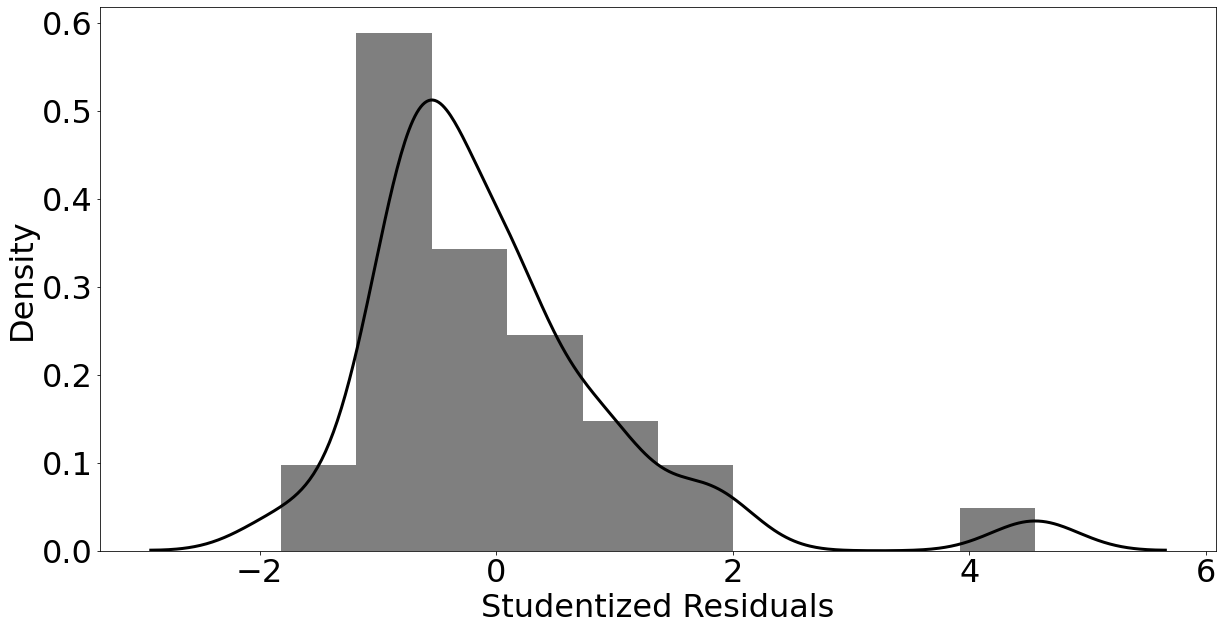

In [44]:
plt.rcParams.update({"font.size":32})
kde = sm.nonparametric.KDEUnivariate(studres)
kde.fit()

fig, ax = plt.subplots(figsize = (20, 10))
ax.hist(studres, color = "k", alpha = .5, density = True)
ax.plot(kde.support, kde.density, color = "k", linewidth = 3)
ax.set_ylabel("Density")
ax.set_xlabel("Studentized Residuals")


## 9.5. Least Absolute Deviations
We can build an estimator that sums the absolute distance, rather than the squared distance of observations from the line. 

Using q = .5, we choose the 50\% quantile which estimates using the median value.

In [45]:
formula = "rdintens ~ I(sales / 1000) + profmarg"
reg_ols = smf.ols(formula = formula,
                 data = rdchem)
results_ols = reg_ols.fit()
OLS_summary(results_ols)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: 0.0761$$,,,,
Intercept,2.6253,4.4835,0.0001,0.5855
I(sales / 1000),0.0534,1.2111,0.2356,0.0441
profmarg,0.0446,0.9661,0.3420,0.0462


In [46]:
reg_lad = smf.quantreg(formula = formula,
                      data = rdchem)
results_lad = reg_lad.fit(q = .5)
OLS_summary(results_lad)

,$\beta $,$t$,$$P>|t|$$,$SE$
$$r^2: nan$$,,,,
Intercept,1.6231,2.3148,0.0279,0.7012
I(sales / 1000),0.0186,0.3529,0.7267,0.0528
profmarg,0.1179,2.1320,0.0416,0.0553
